first we import all the toys we are going to use. PyBaMM being the most important. the bottom three were used in my experimentation but are not necessary for this exercise.

In [97]:
# -*- coding: utf-8 -*-
"""
Created on Thu Oct  1 14:27:47 2020

@author: Ben Cohen
"""
%reset
import pybamm as pb
import numpy as np
import pickle

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


i like to set the logging level as "info" here, so i can track what step the solver is at.
next, we set the options for the model. in this case, we want to see how SEI production evolves. so we tell the model that the SEI production is dependent on the electrochemical reactions occuring in the battery, and that the porosity of the SEI is also variable.

In [98]:
pb.set_logging_level("INFO")

options = {"sei": "ec reaction limited", 
           "sei porosity change": True}

next we will choose the cell model (mathematical model, not phyical model, we will define in a later step). here we will choose the Doyle-Fuller-Newman (DFN) model, which is the default. this comes from another landmark paper in li-ion battery research and seems to be one of the first to most completely describe the reactions in a cell mathematically.

In [99]:
model = pb.lithium_ion.DFN(options)

2020-10-09 11:05:51,012 - [INFO] base_battery_model.build_model(553): Building Doyle-Fuller-Newman model


then, we select a parameter set to define what kind of cell we want to experiment on. in this case we will start with Ramadass 2004, as this was the first landmark paper to develop a model to predict side-reactions and SEI growth. this parameter set has the following values...


these values can be accessed any time by calling...

In [100]:
param = pb.ParameterValues(chemistry=pb.parameter_sets.Ramadass2004)

next, we will get the voltage cutoffs and cell capacity of the model by asking for them explicitly. these are not actually used anywhere in the code, as the values in the experiment section (next) must be unfortunately hard-coded in.

In [101]:
param['Upper voltage cut-off [V]']#4.3
param['Lower voltage cut-off [V]']#2.0
param['Cell capacity [A.h]']# 1 Ah

1.0

now we set up the experiments. which is basically telling a procedure or list of actions to perform on the battery. PyBaMM has a cool feature where you can basically describe what you want to do in plain english. we will start by setting up the baseline experiment, which is to discharge the battery, and then charge it back up using CC-CV charging protocol. below you can see the values from above hardcoded into the experiment description. and the x4 means repeat 4 times. we do this to show the cumulative effect of degradation via SEI thickness and Lithium loss.

the first step is necessary because when the model is initialized, the battery is not at max voltage.

next, we can discharge the battery at a constant, aggressive current of 2C (so, 2A for a cell with capacity 2Ah, meaning it will be empty in 30 minutes). then we charge it back up using a constant current step, then a constant voltage step. here, we will choose a CC-phase current rate of 2C (so 2A), and a CV-phase voltage of 4.1V until the trickle current becomes 50mA. the choice of 2C is more aggressive than the industry standard of 1C, but i figured to make the experiment more evenly-weighted, we should try something more aggressive. hence the choice of 2C as that was the rate of discharge in the prior step, and because later on, when we do pulsed charging, we will experiment with C-rates and duty cycles that equate to this same rate of 2C.

In [102]:
cccv_chargingx4 = pb.Experiment(
        
        ["Charge at 2C until 4.2V"]
            +
        ["discharge at 2C until 2.1V",
        "charge at 2C until 3.78V",
        "hold at 4.1V until 50mA",
        "Rest for 5 minutes",
        ]* 4)

now that we have defined the model, the parameter set, the options, and the experiment, it's time to set upa  simulation and solve the model. we know we will need to do this a few times, and compile/compare and save the results. so let's build a small function to handle all this for us.

first we build a simulation (called sim) using the model, experiment, and parameter values we defined before.
then we put that simulation in a list so we can go back over sims we created earlier. then we call the solve() method from sim
PyBaMM offers a few different solvers, but the the Casadi solver seems to be the most complete and versatile. we will use the "safe" mode option which runs some stricter match to ensure convergence.

we put this in a try/except block in case the solution breaks down. we don't want it to crash the whole method call and we would still like to see how the data turns out up until the solver crashed.

next, we take the solution of the simulation (ie all the signals we could be interested in plotting) and save them in a dictionary with the name we chose 'expName' so we can compare later.
finally, we save the results to disk using PyBaMM's built-in save function (which makes use of the pickle module).


In [103]:
#%% build-solve-run-save
allSolutions = {}
allSims = {}
def buildSolveSave(model, experiment, parameter_values, expName):
    sim = pb.Simulation(model, experiment = experiment, parameter_values = parameter_values)
    allSims[expName] = sim
    try:
        sim.solve(solver=pb.CasadiSolver(mode="safe", dt_max=120))
    except:
        allSolutions[expName] = sim.solution    
        
    allSolutions[expName] = sim.solution    
    sim.save(expName + '.pkl')
    
    

#%%

now that the function is defined, we call it. passing in a more "friendly name" for the experiment handle, which we defined earlier. the friendly name will show up as a way to easily keep track of experiemnts.

uncomment the below line when ready to run. it will take a while and print lots of text to the console, so i will leave it commented out for now.

In [104]:
buildSolveSave(model, cccv_chargingx4, param, 'cccv_chargingx4')

2020-10-09 11:06:10,158 - [INFO] base_battery_model.build_model(553): Building Doyle-Fuller-Newman model
2020-10-09 11:06:32,717 - [INFO] parameter_values.process_model(336): Start setting parameters for Doyle-Fuller-Newman model
2020-10-09 11:06:32,897 - [INFO] base_battery_model.build_model(553): Building Doyle-Fuller-Newman model
2020-10-09 11:06:52,750 - [INFO] parameter_values.process_model(393): Finish setting parameters for Doyle-Fuller-Newman model
2020-10-09 11:06:52,766 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2020-10-09 11:06:52,893 - [INFO] discretisation.process_model(161): Set variable slices for Doyle-Fuller-Newman model
2020-10-09 11:06:52,906 - [INFO] discretisation.process_model(170): Discretise boundary conditions for Doyle-Fuller-Newman model
2020-10-09 11:06:53,166 - [INFO] discretisation.process_model(172): Set internal boundary conditions for Doyle-Fuller-Newman model
2020-10-09 11:06:53,353 - [INFO] base_battery_mo

we will want to plot a number of variables from the solution as a way to compare different charging protocols. the PyBaMM solution object has dozens of variables, every one we could ever hope to measure, but for now we just need these 5 most relevant ones for our comparison. refer back to the README.md to recap why we care about these variables. basically, creation/deposition of SEI is bad for the battery and causes capacity fade and shortens life. loss of Lithium is a similar aging/degradation mechanism that we are trying to prevent.

In [105]:
vitalVars = ["Current [A]",
                "Terminal voltage [V]",
                'Discharge capacity [A.h]',
                "X-averaged total negative electrode sei thickness [m]",
                'Loss of lithium to negative electrode sei [mol]']


now we can use PyBaMM's built-in plotting function to plot the results

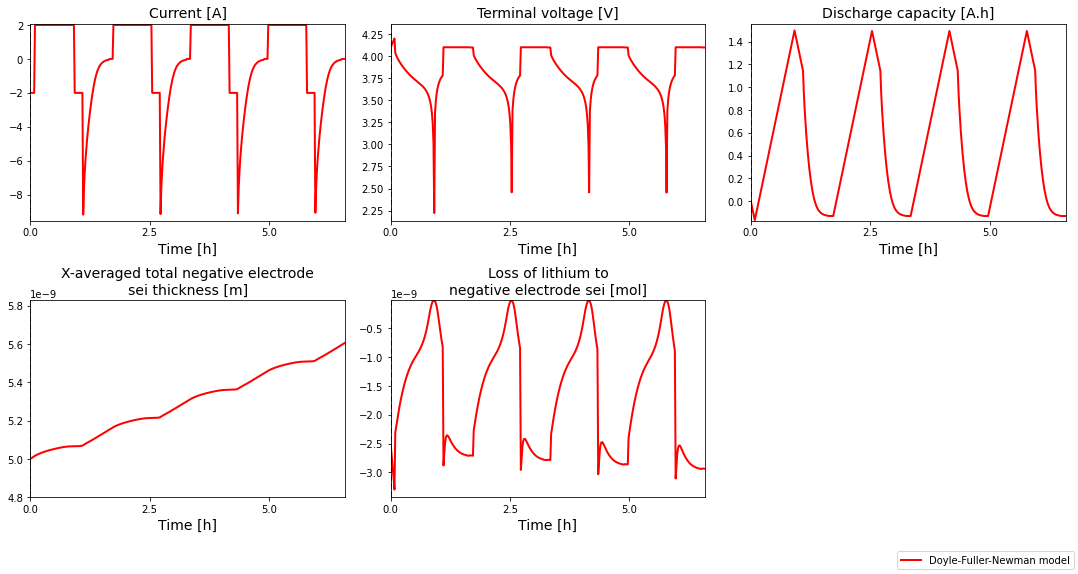

In [106]:
allSims['cccv_chargingx4'].plot(vitalVars)

# Results Discussion - conventional CCCV charging

from these plots we can clearly see the discharge cycles (where current = 2A, terminal voltage decreasing and discharge capacity increasing. it's a bit of misnomer, as what the plot really shows is "discharged capacity". but we will continue referring to it as PyBaMM does. we can also see the constant current step of charging where current = -2A, and the voltage rises logarithmically. then the constant voltage step where the current spikes to ~-9A briefly and raidly climbs up to near 0 as the applied voltage remains constant at 4.1V.  

the bottom two graphs show the important quantites to track degradation/aging. on the bottom left we see the SEI thickness, averaged over the length of the negative electrode over time. we can see that this value is monotonically increasing the cell is charged/discharged, with the steeper increases ocurring during the charging steps, from about 5.0 nm to ~5.6 nm. this change will factor into our determination of the better charging protocol later on.
on the right hand graph we can see that the lithium loss fluctuating with charge and discharge, and even between the CC and CV charging steps. but we also see that the the minimum value of each cycle does get lower each time, from about -2.6nmol to about -2.9nmol. as this project evolves we will dig into this signal more, but for now we will focus on SEI thickness.

now that we understand the results we've gotten, we can do some post-processing on the solution signals to get the quantities for comparison. we'll need to do this a few times so we should write a function for it. but first let's re-run the simulation with only one cycle. that way we are only calculating results from one charging cycle.

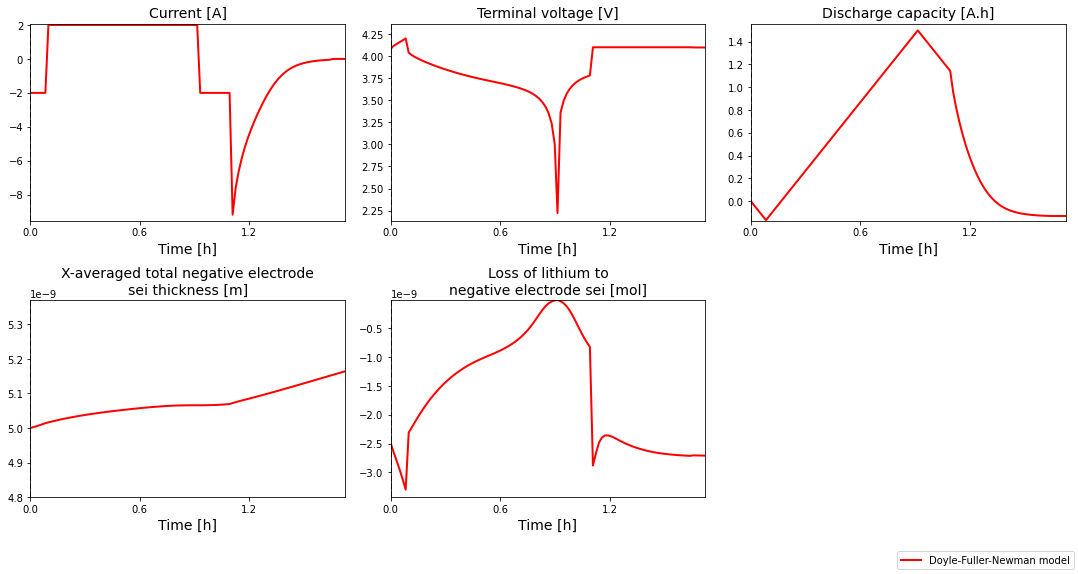

In [107]:
cccv_charging = pb.Experiment(
        
        ["Charge at 2C until 4.2V"]
            +
        ["discharge at 2C until 2.1V",
        "charge at 2C until 3.78V",
        "hold at 4.1V until 50mA",
        "Rest for 5 minutes",
        ]* 1)

buildSolveSave(model, cccv_charging, param, 'cccv_charging')
allSims['cccv_charging'].plot(vitalVars)

the important observation here is that the SEI growth seems to be faster during the CV-step of charging. this is an important clue for later

recall that when we defined the buildSolveSave() we had it automatically add the solution variables to the dictionary data structure, so we can now just access that using the experiment name we want.


steps:
1. return/extract the current and voltage signals from the solution, which we will need to make calculations.
2. calculate charge time. which we will define as the time between when the charging at the chosen "CC-step current" began. and ends when the CV step ends. we will use np.where() to find the first index where the charging current is equal to the current we pass in (which will be the known cc-step current). similarly, the end point is the last index where the voltage is equal to the cv step voltage.
3. calculate Ah discharged (although it is really Ah charged that we care about). we'll calculate this as the max value of the function, minus the ending value
4. calculate SEI thickness delta between the beginning and the end of the charge. for this we will use np.ptp() (stands for "peak to peak"), which simply returns max() - min() of the array. it should be noted that in this model (and it is mostly true in real life), SEI thickness really only builds during charging
5. calcualte SEI growth per unit speed, which is the metric we are using to compare protocols.
6. compile the results into a dictionary. at the same time, calcualate charge speed as charged ah / charge time to get Ah / hour (time-averaged)
7. add results dictionary to compilation dictionary allResults

In [108]:
if 'allResults' not in locals():
    allResults={}
    
def compileCCCVexpResults(expName, ccCurrent, cvVoltage):
    current = allSolutions[expName]['Current [A]'].entries
    voltage = allSolutions[expName]['Terminal voltage [V]'].entries
    idx = np.where(current == -1 * ccCurrent)
    idx2 = np.where(voltage == cvVoltage)
    cccv_chargeTime = allSolutions[expName]['Time [h]'].entries[idx2[0][-1]] - allSolutions[expName]['Time [h]'].entries[idx[0][0]]
    cccv_ah_discharged = np.max(allSolutions[expName]['Discharge capacity [A.h]'].entries) - allSolutions[expName]['Discharge capacity [A.h]'].entries[-1]
    cccv_chargeSpeed = cccv_ah_discharged / cccv_chargeTime
    
    cccv_sei_thic_delta = np.ptp(allSolutions[expName]["X-averaged total negative electrode sei thickness [m]"].entries)
    
    

    cccv_results = {"cc-cv charge time": cccv_chargeTime,
                    "cc-cv charge Ah": cccv_ah_discharged,
                    "cc-cv avg charge speed [Ah/hr]": cccv_chargeSpeed,
                    "cc-cv SEI formation": cccv_sei_thic_delta,
                    "SEI formation per unit charge speed [m/[Ah/hr]]":cccv_sei_thic_delta / cccv_chargeSpeed}

    allResults[expName]=cccv_results

run the above function with arguments matching where we defined the experiment steps, and display those results

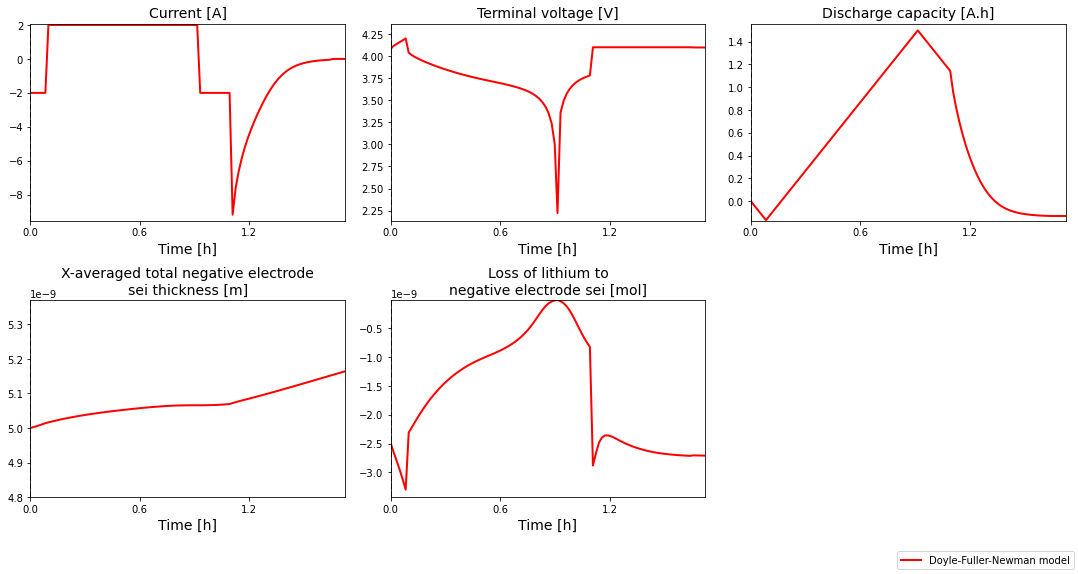

{'cccv_charging': {'cc-cv charge time': 1.6415153021906568,
  'cc-cv charge Ah': 1.6273493926643963,
  'cc-cv avg charge speed [Ah/hr]': 0.9913702238977878,
  'cc-cv SEI formation': 1.6410228221058612e-10,
  'SEI formation per unit charge speed [m/[Ah/hr]]': 1.6553077574327607e-10}}

In [109]:
allSims['cccv_charging'].plot(vitalVars)
compileCCCVexpResults('cccv_charging', 2, 4.1)
allResults['cccv_charging']
allResults

these are the results we will try to beat with pusled charging protocols

so now it's time to define our first pulsed charging protocol. this first protocol is a guess of what the most basic type of pulsed charging protocol might be. regarding the first two steps in the experiment, we are recreating these steps from the cccv experiment, so the cells start their charging in the same state.

given that we are going to charge/rest the battery, let's hit it with some hard current. 6C should do. now intuitively i would think that a pulsed charging protocol would switch between charging and resting at a higher frequency than 1s on, 2s off, but unfortunately PyBaMM does not allow experiment steps lasting less than 1 second. another unfortunate thing is that while a stopping/cutoff point can be defined for an individual step, there is no way to tell pybamm to "break the loop" when a given condition is reached. so we will have to just run this until the model either breaks down, or until we think we have enough cycles for the battery to be charged. i experimented with a few cycle counts for this purpose and 1600 seemed to work.

pybamm does offer the functionality to define a custom current function (ie load profile, comprising charging and discharging). and that may be the better way to do this. ie, we could define a square wave at any frequency/duty cycle and have that be the charging protocol. but in order to use that functionality you must hardcode the current function into the model - you can't simply run an experiment using it. so for simplicity, and for the optics of running two experiments side by side on the same model, we will stick with this method for now.

In [110]:
pulse1 = pb.Experiment(
        ["Charge at 2C until 4.2V",            
        "discharge at 2C until 2.1V"]
        +        
        ["charge at 6C for 1 second or until 4.15V",
         "rest for 2 s"] * 1600)

now we can build/solve/save this experiment using the same model, and compile the solution and variables into the dictionary. in the same step we will also plot the variables we care about, the list of which we will retain from our prior definition of 'vitalVars'. be aware this simulation will take a long time to run and print lots of text (thousands of lines) to the console. to prevent this, simply change the logging level. uncomment to run on your own. for readability, i have run this on my machine locallay and pickled the solution object into a variable, which i will load to carry on the demonstration

In [111]:
#buildSolveSave(model, pulse1, param, '6C charge, 2s rest')
#allSims['6C charge, 2s rest'].plot(vitalVars

In [121]:
with open('charge6rest2.pkl', 'rb') as f:
    allSolutions['6C charge, 2s rest']=pickle.load(f)

# results discussion - pulsed charging
![](6C charge, 2s rest.jpg)
![](Documents/GitHub/battery_modeling/6C charge, 2s rest.jpg)

![](6C charge, 2s rest, zoomed.jpg)
![](Documents/GitHub/battery_modeling/6C charge, 2s rest, zoomed.jpg)

here we can see the signals we would expect from one cycle of discharge followed by one cycle of pulsed charge. when we zoom in we can see the proper duty cycle (0.33) with the proper current (6C rate) of 6A for a 1Ah cell. and the terminal voltage behaving accordingly. the other interesting thing to note is that the SEI thickness does not change very much at all, and the lithium loss at the end of charging returns to a value close to what it was at the start of the discharge. of course, we are only showing one charge cycle here, as showing multiple cycles will take lots of computating time. 

now we will need another function to extract the actual results values from the solution signals. the pulsed protocols will need a separate function from the cccv protocol.

steps:
1. get solution
2. use np.where to locate all current points having current less than -3.5A. 
3. the first represents the beginning of the charge. so we get the time associated with that index
4. the end of the charge we'll define as the last point where the current was at its pulsing value 
5. calculate charge time as time delta between these times
6. calculate Ah discharged (or Ah charged really) as [max] - [last entry] in Ah discharged signal
7. calculate SEI thickness delta as peak-to-peak values of signal
8. compile results in dictionary, calculating charge speed as avg Ah/hour 
9. calculate SEI deposition as meters of sei per unit charge speed [m/[Ah/hr]]
10. store results dictionary in compilation allResults

In [112]:
if 'allResults' not in locals():
    allResults={}

def compilePulsedExpResults(expName, pulseCurrent):
    pulsed_sol = allSolutions.get(expName)
    
    current = pulsed_sol['Current [A]'].entries
    idx = np.where(current == -1* pulseCurrent)
    
    time = pulsed_sol['Time [h]'].entries
    
    pulsed_chargeTime = time[idx[0][-1]] - time[idx[0][0]]
    pulsed_ah_discharged = np.max(pulsed_sol['Discharge capacity [A.h]'].entries) - pulsed_sol['Discharge capacity [A.h]'].entries[-1]
    pulsed_chargeSpeed = pulsed_ah_discharged / pulsed_chargeTime
    pulsed_sei_thic_delta = np.ptp(pulsed_sol["X-averaged total negative electrode sei thickness [m]"].entries)

    pulsed_results = {"pulsed charge time": pulsed_chargeTime,
                      "pulsed charge Ah": pulsed_ah_discharged,
                      "pulsed avg charge speed [Ah/hr]": pulsed_ah_discharged/pulsed_chargeTime,
                      "pulsed SEI formation": pulsed_sei_thic_delta,
                      "SEI formation per unit charge speed [m/[Ah/hr]]":pulsed_sei_thic_delta / pulsed_chargeSpeed}


    allResults[expName]=pulsed_results

now call the function and display the results

In [123]:
compilePulsedExpResults('6C charge, 2s rest', 6)
allResults

{'cccv_charging': {'cc-cv charge time': 1.6415153021906568,
  'cc-cv charge Ah': 1.6273493926643963,
  'cc-cv avg charge speed [Ah/hr]': 0.9913702238977878,
  'cc-cv SEI formation': 1.6410228221058612e-10,
  'SEI formation per unit charge speed [m/[Ah/hr]]': 1.6553077574327607e-10},
 '6C charge, 2s rest': {'pulsed charge time': 0.6758333333333079,
  'pulsed charge Ah': 1.3566666666665388,
  'pulsed avg charge speed [Ah/hr]': 2.0073982737360145,
  'pulsed SEI formation': 1.1085864702253831e-10,
  'SEI formation per unit charge speed [m/[Ah/hr]]': 5.5225038535186526e-11}}

the pulsed charging protocol gave us a decently faster charging speed, but drastically reduced the SEI production. hence causing a much lower "SEI growth per unit speed" value.

let's see if we can do even better. recall that 6C charge rate and 0.33 duty cycle for the pulses was somewhat arbitrary. let's try tuning these parameters. we will create 2 more experiments. one where we will relax the current but only give the cell 1s rest in between pulses (ie 0.50 duty cycle), and one where we will beef up the current and increase the rest. (8C current, 0.25 duty).

In [ ]:
pulse2 = pb.Experiment(
        ["Charge at 2C until 4.2V",            
        "discharge at 2C until 2.1V"]
        +        
        ["charge at 4C for 1 second or until 4.15V",
         "rest for 1 s"] * 1600)

pulse3 = pb.Experiment(
        ["Charge at 2C until 4.2V",            
        "discharge at 2C until 2.1V"]
        +        
        ["charge at 8C for 1 second or until 4.15V",
         "rest for 3 s"]*1600)
    

let's build/solve/save these simulations and compile their results. once again, this will take a long time. so i ran these on my machine and will load in the pickled results. uncomment lines below to run for yourself

In [ ]:
#buildSolveSave(model, pulse2, param, '4C charge, 1s rest')
#buildSolveSave(model, pulse3, param, '8C charge, 3s rest')
#allSims['4C charge, 1s rest'].plot(vitalVars)
#allSims['8C charge, 3s rest'].plot(vitalVars)

In [124]:
with open('charge8rest3.pkl', 'rb') as f:
    allSolutions['8C charge, 3s rest']=pickle.load(f)
    
with open('charge4rest1.pkl', 'rb') as f:
    allSolutions['4C charge, 1s rest']=pickle.load(f)

In [125]:
compilePulsedExpResults('4C charge, 1s rest', 4)
compilePulsedExpResults('8C charge, 3s rest', 8)

allResults

{'cccv_charging': {'cc-cv charge time': 1.6415153021906568,
  'cc-cv charge Ah': 1.6273493926643963,
  'cc-cv avg charge speed [Ah/hr]': 0.9913702238977878,
  'cc-cv SEI formation': 1.6410228221058612e-10,
  'SEI formation per unit charge speed [m/[Ah/hr]]': 1.6553077574327607e-10},
 '6C charge, 2s rest': {'pulsed charge time': 0.6758333333333079,
  'pulsed charge Ah': 1.3566666666665388,
  'pulsed avg charge speed [Ah/hr]': 2.0073982737360145,
  'pulsed SEI formation': 1.1085864702253831e-10,
  'SEI formation per unit charge speed [m/[Ah/hr]]': 5.5225038535186526e-11},
 '4C charge, 1s rest': {'pulsed charge time': 0.7333333333331571,
  'pulsed charge Ah': 1.469999999999673,
  'pulsed avg charge speed [Ah/hr]': 2.0045454545454904,
  'pulsed SEI formation': 1.180829856252278e-10,
  'SEI formation per unit charge speed [m/[Ah/hr]]': 5.890761187652982e-11},
 '8C charge, 3s rest': {'pulsed charge time': 0.6144444444443988,
  'pulsed charge Ah': 1.2333333333330265,
  'pulsed avg charge spee

# Results Discussion

okay. so it seems like charging the battery with a higher current, even at the expense of longer rest periods both helps the battery charge faster, as well as mitigates SEI production. i would imagine that up to a point, this trend would continue until we reach a current that is too high. as for where that point is, it would either be a manufacturer's quoted limit, a limit of the components in the BMS, or at some point there will reach a current that will cause too much heating within the cell. this heating may then trigger another mechanism of aging/degradation within the cell. hence some limit would need to be found and obeyed to charge quickly while preventing other types of damage to the cell. then again, we have only scratched the surface of the kinds of square wave shapes we could use as charging protocols.

# Conclusion and future work
This was only a short project because of the minimal time i have had to work on it before sharing this week. i acknowledge it was only a simple task accomplished here and there, and there is much deeper investigation that could be done here. here are a few ideas...
-  if we could increase the frequency of the square wave we could keep the 0.25 duty cycle with an even higher current, or we maintain the same duty cycle and charge the battery faster. 
- we could vary the amplitude of the charge pulses and adjust them based on real-time temperature measurements, such that we could charge with pulses of very high current and stay beneath thermal limits.
- we could vary the shape of the square wave, with some peaks at high current and some at lower currents. or use mostly-square pulses with exponentially declining tails, which may help with intercalation of lithium into the graphite.
- while it is the most prominent in literature, SEI is not the only capacity fade mechanism or side reaction occuring in li-ion cells. others include loss of active material (graphite) an dintercalation sites, which is exacerbated by fast charge/discharge cycling rates, electrolyte decomposition, and solvent co-intercalation which breaks down the graphite structure. and this is all just at the negative electrode. the positive electrode has its own set of concerns, like phase transitions, lithium sites being cracked or lost, or metal dissolution. when developing a charging protocol, we would have to be careful that we are not exacerbating any of these effects while trying to minimize SEI growth. hence why an advanced or auxilary BMS that could take measurements of cell internals on a fast time scale may be necesssary.
- it would be great to run these experiments on different cell models - both mathematical and physical. the DFN model isn't the only one out there, and it would be interesting to see how those models behave under different charging protocols, especially as they may elect to model degradation differently. same with parameter sets. Ramadass et al. are not the only group who attempted to model SEI growth. 
- also, we did not compare pulsed charging protocols to any other protocols that may be out there. [cite et al] investigates six charging protocols and discusses pros and cons of each. but we have not done a head-to-head against any others, which may be present out there in BMS devices controlling consumer electronics.


## thanks for following along! i would love to hear some feedback on this demonstration, or suggestions for future work